<a href="https://colab.research.google.com/github/krishbharucha/SpatioTemporal-Ensemble/blob/main/SpatioTemporal_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taxi Trajectory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### We have provided with the dataset describing a complete year (from 1 july 2013 to 30 june 2014) of the trajectories for all the 442 taxies running in the city of portugal.
#### We are hired by the transportation industry of portugal and want to predict the total travel time of the trip based on the attributes given in the datasets.

## Data Overview

Each data point corresponds to one complete trip. It contains a total 9 features

* TRIP_ID (string) : It contains an unique identifier for each trip
* CALL_TYPE (char) :  It identifies the way used to demand this service. It may contain one of three possible values.
                      1. 'A' : if this trip was dispatched from the central
                      2. 'B' : if this trip was demanded directly to a taxi driver on a specific stand
                      3. 'C' : otherwise (i.e. a trip demanded on a random street)
* ORIGIN_CALL (integer) :  It contains an unique identifier for each phone number which was used to demand, at least, one service. It identifies the trip’s customer if CALL_TYPE=’A’. Otherwise, it assumes a NULL value
* ORIGIN_STAND (integer): It contains an unique identifier for the taxi stand. It identifies the starting point of the trip if CALL_TYPE=’B’. Otherwise, it assumes a NULL value
* TAXI_ID: (integer): It contains an unique identifier for the taxi driver that performed each trip
* TIMESTAMP (integer) : Unix Timestamp (in seconds). It identifies the trip’s start
* DAYTYPE (char) : It identifies the daytype of the trip’s start. It assumes one of three possible values
                    1. 'B' : if this trip started on a holiday or any other special day (i.e. extending holidays, floating holidays, etc.)
                    2. 'C' : if the trip started on a day before a type-B day
                    3. 'A' : otherwise (i.e. a normal day, workday or weekend)
* MISSING_DATA (Boolean) : It is FALSE when the GPS data stream is complete and TRUE whenever one (or more) locations are missing.
* POLYLINE (String): It contains a list of GPS coordinates (i.e. WGS84 format) mapped as a string.The last list item corresponds to the trip’s destination while the first one represents its start. The beginning and the end of the string are identified with brackets (i.e. [ and ], respectively). Each pair of coordinates is also identified by the same brackets as [LONGITUDE, LATITUDE]. This list contains one pair of coordinates for each 15 seconds of trip. The POLYLINE can have multiple pairs of longitude and latitude


The total travel time of the trip (the prediction target) is defined as the (number of points-1) x 15 seconds. For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds.




##### Type of Machine Learning task :
It is an regression problem where given a set of features we need to predict the total travel time by taxi from starting of ride to the destination in seconds.
                    
                

#### Performace Metric
Since it is an regression problem we will use Root Mean Squared error (RMSE) and R-squared as regression metric.

#### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from math import sqrt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor

import joblib

### EDA, Data Cleaning and Feature Engineering

#### Load the taxi trajectory data from CSV file

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML Mini Project/train.csv')

In [ ]:
df.shape

(1710670, 9)

The dataset has around 171K instances each of which has 9 different feature values.

In [ ]:
df.columns

Index(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
       'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE'],
      dtype='object')

Displying the first 10 rows.

In [ ]:
df.head(10)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
5,1372636965620000231,C,NaN,NaN,20000231,1372636965,A,False,"[[-8.615502,41.140674],[-8.614854,41.140926],[..."
6,1372637210620000456,C,NaN,NaN,20000456,1372637210,A,False,"[[-8.57952,41.145948],[-8.580942,41.145039],[-..."
7,1372637299620000011,C,NaN,NaN,20000011,1372637299,A,False,"[[-8.617563,41.146182],[-8.617527,41.145849],[..."
8,1372637274620000403,C,NaN,NaN,20000403,1372637274,A,False,"[[-8.611794,41.140557],[-8.611785,41.140575],[..."
9,1372637905620000320,C,NaN,NaN,20000320,1372637905,A,False,"[[-8.615907,41.140557],[-8.614449,41.141088],[..."


Filtering out categorical features.

In [ ]:
df.dtypes[df.dtypes == 'object']

,0
CALL_TYPE,object
DAY_TYPE,object
POLYLINE,object


In [ ]:
df.isnull().sum()

,0
TRIP_ID,0
CALL_TYPE,0
ORIGIN_CALL,1345900
ORIGIN_STAND,904091
TAXI_ID,0
TIMESTAMP,0
DAY_TYPE,0
MISSING_DATA,0
POLYLINE,0


There are many missing values in ORIGIN_CALL and ORIGIN_STAND because may be all the taxi users have not called the via phone and they have not started their trip from taxi stand.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TRIP_ID       int64  
 1   CALL_TYPE     object 
 2   ORIGIN_CALL   float64
 3   ORIGIN_STAND  float64
 4   TAXI_ID       int64  
 5   TIMESTAMP     int64  
 6   DAY_TYPE      object 
 7   MISSING_DATA  bool   
 8   POLYLINE      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


In [ ]:
df.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP
count,1.710670e+06,364770.000000,806579.000000,1.710670e+06,1.710670e+06
mean,1.388622e+18,24490.363018,30.272381,2.000035e+07,1.388622e+09
std,9.180944e+15,19624.290043,17.747840,2.112405e+02,9.180944e+06
min,1.372637e+18,2001.000000,1.000000,2.000000e+07,1.372637e+09
25%,1.380731e+18,6593.000000,15.000000,2.000017e+07,1.380731e+09
50%,1.388493e+18,18755.000000,27.000000,2.000034e+07,1.388493e+09
75%,1.396750e+18,40808.000000,49.000000,2.000052e+07,1.396750e+09
max,1.404173e+18,63884.000000,63.000000,2.000098e+07,1.404173e+09


Describing the categorical features.

In [ ]:
df.describe(include = ['object'])

,CALL_TYPE,DAY_TYPE,POLYLINE
count,1710670,1710670,1710670
unique,3,1,1703650
top,B,A,[]
freq,817881,1710670,5901


We can see the DAY_TYPE has only 1 unique value and that is 'A' which means that all the trips are started on normal day or weekend. Also the 5901 observations don't have the POLYLINE values means we cannot calculate the travel time for those trips.

##### Sorting the entire dataset based on the timestamp

In [ ]:
df.sort_values('TIMESTAMP',inplace = True)

In [ ]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,False,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,False,"[[-8.619894,41.148009],[-8.620164,41.14773],[-..."
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,False,"[[-8.617599,41.146137],[-8.617581,41.14593],[-..."


In [ ]:
df['year'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).year)
df['month'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).month)
df['month_day'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).day)
df['hour'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).hour)
df['week_day'] = df['TIMESTAMP'].apply(lambda x :datetime.datetime.fromtimestamp(x).weekday())

In [ ]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,year,month,month_day,hour,week_day
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,False,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8...",2013,7,1,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,False,"[[-8.619894,41.148009],[-8.620164,41.14773],[-...",2013,7,1,0,0
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,False,"[[-8.617599,41.146137],[-8.617581,41.14593],[-...",2013,7,1,0,0


Pie chart for the year

([<matplotlib.patches.Wedge at 0x7965875be770>,
 [Text(-0.0067795454598015585, 1.0999791078758536, '2013'),
  Text(0.006779648447278292, -1.0999791072411018, '2014')],
 [Text(-0.0036979338871644856, 0.59998860429592, '50.2%'),
  Text(0.003697990062151795, -0.5999886039496919, '49.8%')])

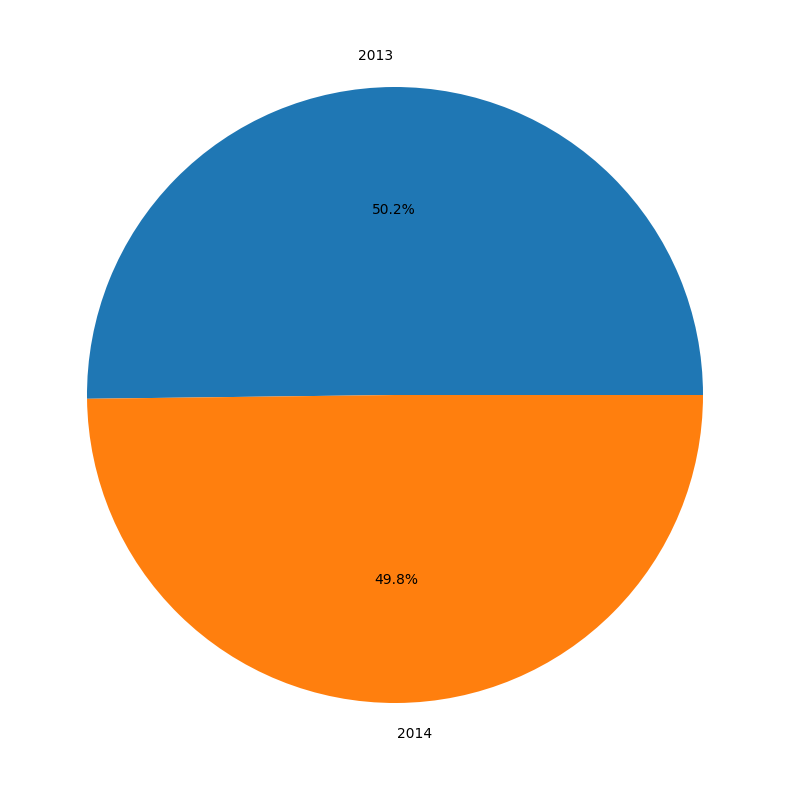

In [ ]:
plt.figure(figsize = (10,10))
plt.pie(df['year'].value_counts(), labels = df['year'].value_counts().keys(),autopct = '%.1f%%')

From the above pie chart it is clear that there are equal number of taxi trips in both the year.

Text(0, 0.5, 'Day')

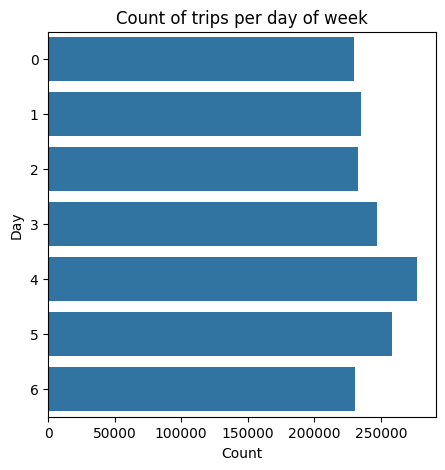

In [ ]:
plt.figure(figsize = (5,5))
plt.title('Count of trips per day of week')
sns.countplot(y = 'week_day', data = df)
plt.xlabel('Count')
plt.ylabel('Day')

The 4th and 5th day of week has almost same number of trips and rest all the days have almost similar number of trips. This means that we can say each and every day of week required same number of taxies irrespective of weekend or working day.

Text(0, 0.5, 'Month')

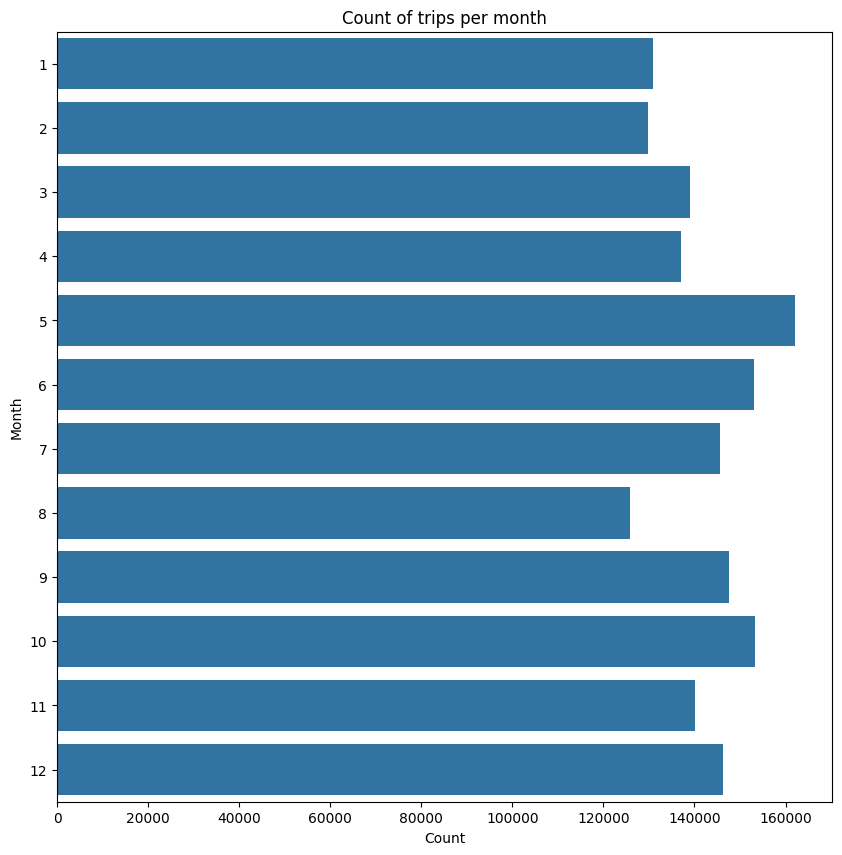

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Count of trips per month')
sns.countplot(y = 'month', data = df)
plt.xlabel('Count')
plt.ylabel('Month')

On an average we can say that every month has atleast 120000 taxi trips planned.

Text(0, 0.5, 'Hours')

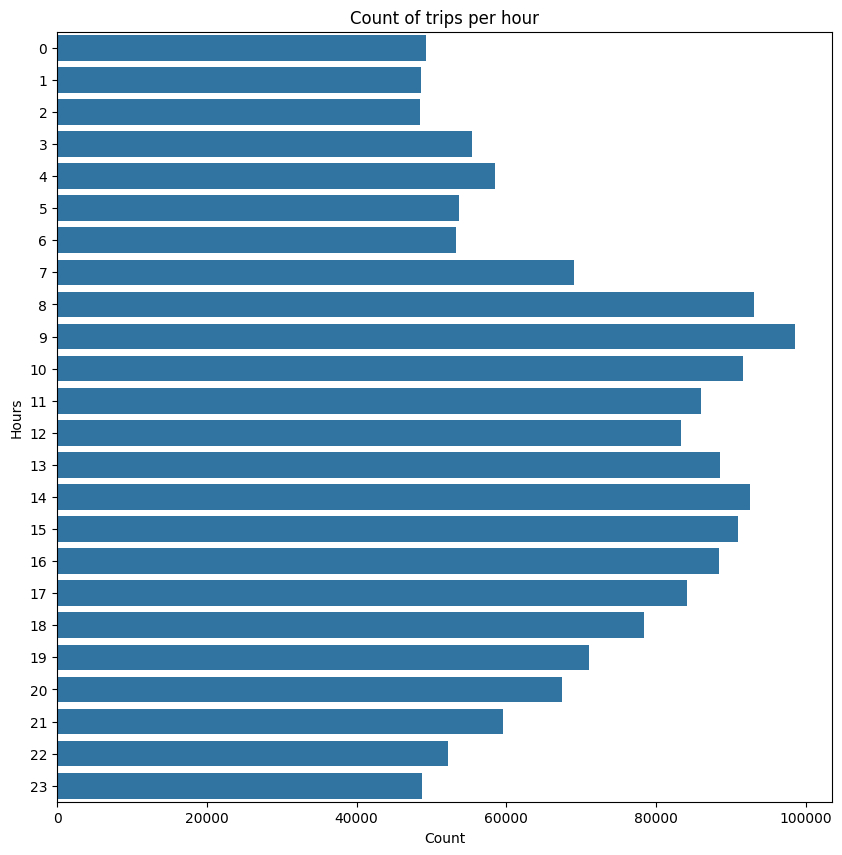

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Count of trips per hour')
sns.countplot(y = 'hour', data = df)
plt.xlabel('Count')
plt.ylabel('Hours')

14th and 15th hour may be the peak hours, office time, school time because lot of taxies are used between this time.

In [ ]:
df['MISSING_DATA'].value_counts()

,count
MISSING_DATA,
False,1710660
True,10


For 10 instances the GPS data steam is not complete and there can be one or more locations missing. Such a data points wont gives us the appropriate trip time so we can drop such observations.

In [ ]:
df.drop(df[df['MISSING_DATA'] == True].index, inplace = True)

In [ ]:
df['MISSING_DATA'].unique()

array([False])

Also some of the POLYLINES values are missing in which we cannot find the trip time, dropping such observations is also the good idea.

In [ ]:
df[df['POLYLINE'] =='[]']['POLYLINE'].value_counts()

,count
POLYLINE,
[],5901


In [ ]:
df.drop(df[df['POLYLINE'] =='[]']['POLYLINE'].index, inplace = True)

In [ ]:
df[df['POLYLINE'] =='[]']['POLYLINE'].value_counts()

,count
POLYLINE,


#### Convreting a POLYLINE into the total travelling time.

In [ ]:
df['Polyline Length'] = df['POLYLINE'].apply(lambda x : len(eval(x))-1)

In [ ]:
df['Trip Time(sec)'] = df['Polyline Length'].apply(lambda x : x * 15)

In [ ]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,year,month,month_day,hour,week_day,Polyline Length,Trip Time(sec)
577,1372636853620000380,C,NaN,NaN,20000380,1372636853,A,False,"[[-8.610291,41.140746],[-8.6103,41.140755],[-8...",2013,7,1,0,0,24,360
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0,42,630
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0,22,330
10,1372636875620000233,C,NaN,NaN,20000233,1372636875,A,False,"[[-8.619894,41.148009],[-8.620164,41.14773],[-...",2013,7,1,0,0,21,315
64,1372636896620000360,C,NaN,NaN,20000360,1372636896,A,False,"[[-8.617599,41.146137],[-8.617581,41.14593],[-...",2013,7,1,0,0,42,630


In [ ]:
# If your DataFrame has a default integer index
if 3728 in df.index:
    trip_time_sec = df.loc[3728, 'Trip Time(sec)']
    print(f"Trip Time for row with index 3728: {trip_time_sec} seconds")
else:
    print("Row with index 3728 does not exist in the DataFrame.")

# If you want to access the row by its position (useful if you're sure of the row count)
trip_time_sec_by_pos = df.iloc[3728]['Trip Time(sec)']
print(f"Trip Time for row at position 3728: {trip_time_sec_by_pos} seconds")


Trip Time for row with index 3728: 1245 seconds
Trip Time for row at position 3728: 1110 seconds


In [ ]:
df['Trip Time(sec)'].describe()

,Trip Time(sec)
count,1.704759e+06
mean,7.189021e+02
std,6.846122e+02
min,0.000000e+00
25%,4.050000e+02
50%,6.000000e+02
75%,8.700000e+02
max,5.820000e+04


Above description clear that the minimum travelling time by the taxi is 15 seconds and maximum is 58200 seconds i.e.around 16 hours 16 min.

In [ ]:
# df.groupby('week_day').mean()
# Select only the numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Group by 'week_day' and calculate the mean for numeric columns only
result = numeric_cols.groupby(df['week_day']).mean()


On an average each day of week 648 to 750 seconds of journey were travelled.

In [ ]:
df['DAY_TYPE'].isnull().sum()

0

#### One Hot Encoding for Call Type

In [ ]:
df = pd.get_dummies(df, columns=['CALL_TYPE'])

#### Dropping the duplicates

In [ ]:
df.shape

(1704759, 18)

In [ ]:
df = df.drop_duplicates()
print(df.shape)

(1704757, 18)


There were 2 duplicate rows which was dropped.

#### Saving the final dataframe for future use.

In [ ]:
df.to_csv('Cleaned_data.csv', index = None)

#### Data Preparation for ML models.

In [ ]:
df = df.iloc[:50000]

In [ ]:
df.shape

(50000, 18)

In [ ]:
X = df[['Polyline Length', 'CALL_TYPE_A', 'CALL_TYPE_B', 'CALL_TYPE_C']]
y = df['Trip Time(sec)']

#### Data Standardization

In [ ]:
s = StandardScaler()
X = s.fit_transform(X)

In [ ]:
print(np.mean(X))
np.std(X)

-6.821210263296962e-18


1.0

#### Train and Test splits : 70-30

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.3)

In [ ]:
print("The size of training input is", X_train.shape)
print("The size of training output is", y_train.shape)
print(50 *'*')
print("The size of testing input is", X_test.shape)
print("The size of testing output is", y_test.shape)

The size of training input is (35000, 4)
The size of training output is (35000,)
**************************************************
The size of testing input is (15000, 4)
The size of testing output is (15000,)


### Machine Learning Models

#### 1. Baseline Model
* In baseline model the predicted trip time would be simply the average of all trip time.
* We will use this baseline model to perform hypothesis testing for other ML complex models.

In [ ]:
y_train_pred = np.ones(X_train.shape[0]) * y_train.mean() #Predicting the train results

In [ ]:
y_test_pred = np.ones(y_test.shape[0]) * y_train.mean() #Predicting the test results

In [ ]:
print("Train Results for Baseline Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Baseline Model:
--------------------------------------------------
Root mean squared error:  696.1281231177262
R-squared:  0.0


In [ ]:
print("Test Results for Baseline Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Baseline Model:
--------------------------------------------------
Root mean squared error:  658.6342580220878
R-squared:  -1.5826004062802213e-08


#### 2. KNN Regressor

In [ ]:
k_range  =list(range(1,30))
param =dict(n_neighbors =k_range)
knn_regressor =GridSearchCV(KNeighborsRegressor(),param,cv =10)
knn_regressor.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]})

In [ ]:
print(knn_regressor.best_estimator_)
knn_regressor.best_params_

KNeighborsRegressor(n_neighbors=1)


{'n_neighbors': 1}

In [ ]:
y_train_pred =knn_regressor.predict(X_train) ##Predict train result
y_test_pred =knn_regressor.predict(X_test) ##Predict test result


In [ ]:
print("Train Results for KNN Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for KNN Regressor Model:
--------------------------------------------------
Root mean squared error:  0.0
R-squared:  1.0


In [ ]:
print("Test Results for KNN Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for KNN Regressor Model:
--------------------------------------------------
Root mean squared error:  34.69380348131349
R-squared:  0.9972253053122103


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
from math import sqrt

# Initial hyperparameters
current_k = 5  # Start with a random or average value for k
step_size = 1  # Define the step size for neighbor search
max_iter = 30  # Set a maximum number of iterations
best_k = current_k

# Initialize model and evaluate performance
knn_regressor = KNeighborsRegressor(n_neighbors=current_k)
knn_regressor.fit(X_train, y_train)
best_train_rmse = sqrt(mse(y_train.values, knn_regressor.predict(X_train)))

for i in range(max_iter):
    print(f"Iteration {i+1}: Current k = {current_k}, Train RMSE = {best_train_rmse}")

    # Try a neighboring configuration
    new_k = current_k + step_size
    if new_k <= 0 or new_k > len(X_train):  # Ensure k is within valid range
        break

    # Train and evaluate the new model
    knn_regressor = KNeighborsRegressor(n_neighbors=new_k)
    knn_regressor.fit(X_train, y_train)
    new_train_rmse = sqrt(mse(y_train.values, knn_regressor.predict(X_train)))

    # Compare performances
    if new_train_rmse < best_train_rmse:
        best_k = new_k
        best_train_rmse = new_train_rmse
        current_k = new_k
    else:
        # If no improvement, break the loop (you could also consider reducing the step size)
        break

# Final model with the best k found
print(f"Best k found: {best_k} with Train RMSE: {best_train_rmse}")

# Evaluate on the test set
knn_regressor = KNeighborsRegressor(n_neighbors=best_k)
knn_regressor.fit(X_train, y_train)
y_test_pred = knn_regressor.predict(X_test)
print("Test Results for Optimized KNN Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))


Iteration 1: Current k = 5, Train RMSE = 54.28779499771828
Best k found: 5 with Train RMSE: 54.28779499771828
Test Results for Optimized KNN Regressor Model:
--------------------------------------------------
Root mean squared error:  30.045864940121128
R-squared:  0.9979189582372257


In [ ]:
import random

# Ensure the model is trained with the optimal k
knn_regressor = KNeighborsRegressor(n_neighbors=best_k)
knn_regressor.fit(X_train, y_train)

# Randomly select a taxi trip ID from the test dataset
random_index = random.randint(0, len(X_test) - 1)
random_taxi_trip = X_test[random_index].reshape(1, -1)  # Reshape for prediction

# Predict the travel time for the selected random taxi trip
predicted_travel_time = knn_regressor.predict(random_taxi_trip)

# Output the predicted travel time
print(f"Predicted Travel Time for Random Taxi Trip ID {random_index}: {predicted_travel_time[0]}")



Predicted Travel Time for Random Taxi Trip ID 10819: 690.0


In [ ]:
# If your DataFrame has a default integer index
if 3728 in df.index:
    trip_time_sec = df.loc[3728, 'Trip Time(sec)']
    print(f"Trip Time for row with index 3728: {trip_time_sec} seconds")
else:
    print("Row with index 3728 does not exist in the DataFrame.")

# If you want to access the row by its position (useful if you're sure of the row count)
trip_time_sec_by_pos = df.iloc[3728]['Trip Time(sec)']
print(f"Trip Time for row at position 3728: {trip_time_sec_by_pos} seconds")


Trip Time for row with index 3728: 1245 seconds
Trip Time for row at position 3728: 1110 seconds


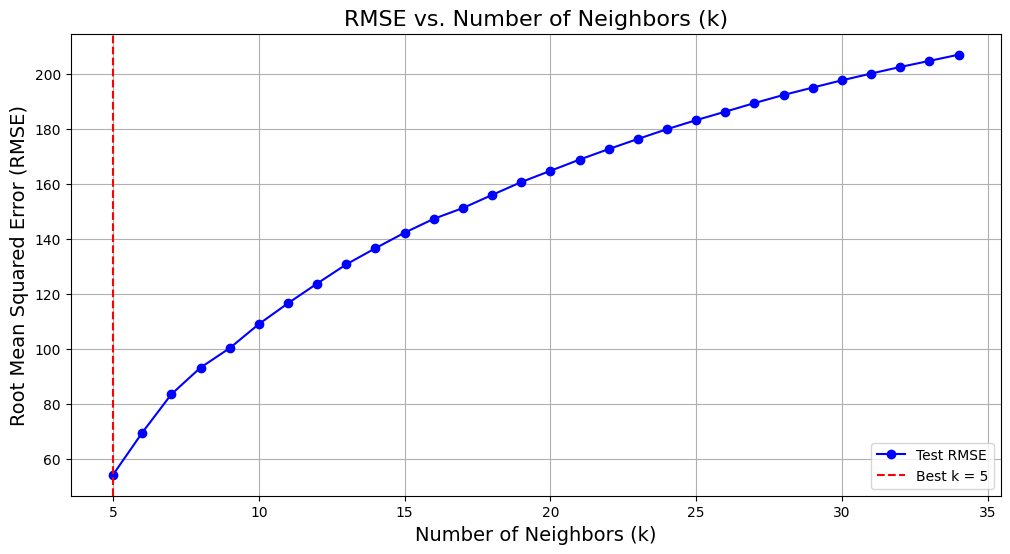

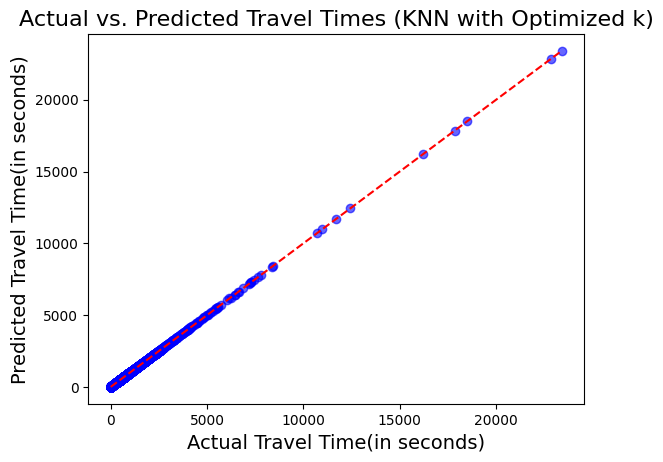

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `best_k`, `best_train_rmse`, and `y_test_pred` are defined from your code above

# Data collection during hill climbing
k_values = []
train_rmse_values = []
current_k = 5
step_size = 1
max_iter = 30

# Re-running the loop to collect data for plotting
for i in range(max_iter):
    knn_regressor = KNeighborsRegressor(n_neighbors=current_k)
    knn_regressor.fit(X_train, y_train)
    train_rmse = sqrt(mse(y_train.values, knn_regressor.predict(X_train)))

    k_values.append(current_k)
    train_rmse_values.append(train_rmse)

    new_k = current_k + step_size
    if new_k > len(X_train):
        break
    current_k = new_k

# Line Plot: RMSE vs. Number of Neighbors (k)
plt.figure(figsize=(12, 6))
plt.plot(k_values, train_rmse_values, marker='o', color='b', label='Test RMSE')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel('Number of Neighbors (k)', fontsize=14)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=14)
plt.title('RMSE vs. Number of Neighbors (k)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot: Actual vs. Predicted Values

plt.scatter(y_test, y_test_pred, color='b', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel('Actual Travel Time(in seconds)', fontsize=14)
plt.ylabel('Predicted Travel Time(in seconds)', fontsize=14)
plt.title('Actual vs. Predicted Travel Times (KNN with Optimized k)', fontsize=16)

plt.show()


In [ ]:
print("hi")

hi


We can see that the training RMSE error is low but testing RMSE error is high which means that model is overfitting.

#### 3. Ridge Regressor

In [ ]:
params ={'alpha' :[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
ridge_regressor =GridSearchCV(Ridge(), params ,cv =5,scoring = 'neg_mean_absolute_error', n_jobs =-1)
ridge_regressor.fit(X_train ,y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             scoring='neg_mean_absolute_error')

In [ ]:
print(ridge_regressor.best_estimator_)
ridge_regressor.best_params_

Ridge(alpha=0.0001)


{'alpha': 0.0001}

In [ ]:
y_train_pred =ridge_regressor.predict(X_train) ##Predict train result
y_test_pred =ridge_regressor.predict(X_test) ##Predict test result

In [ ]:
print("Train Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Ridge Regressor Model:
--------------------------------------------------
Root mean squared error:  1.9331253032751084e-06
R-squared:  1.0


In [ ]:
print("Test Results for Ridge Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Ridge Regressor Model:
--------------------------------------------------
Root mean squared error:  1.8284171999655038e-06
R-squared:  1.0


#### 4. Lasso Regression

In [ ]:
params ={'alpha' :[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
lasso_regressor =GridSearchCV(Lasso(), params ,cv =15,scoring = 'neg_mean_absolute_error', n_jobs =-1)
lasso_regressor.fit(X_train ,y_train)

GridSearchCV(cv=15, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]},
             scoring='neg_mean_absolute_error')

In [ ]:
print(lasso_regressor.best_estimator_)
lasso_regressor.best_params_

Lasso(alpha=0.0001)


{'alpha': 0.0001}

In [ ]:
y_train_pred =lasso_regressor.predict(X_train) ##Predict train result
y_test_pred =lasso_regressor.predict(X_test) ##Predict test result

In [ ]:
print("Train Results for Lasso Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Lasso Regressor Model:
--------------------------------------------------
Root mean squared error:  9.841513824428806e-05
R-squared:  0.99999999999998


In [ ]:
print("Test Results for Lasso Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Lasso Regressor Model:
--------------------------------------------------
Root mean squared error:  9.311444172261304e-05
R-squared:  0.99999999999998


#### 5. Decision Tree Regressor

In [ ]:
depth  =list(range(3,30))
param_grid =dict(max_depth =depth)
tree =GridSearchCV(DecisionTreeRegressor(),param_grid,cv =10)
tree.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29]})

In [ ]:
print(tree.best_estimator_)
tree.best_params_

DecisionTreeRegressor(max_depth=19)


{'max_depth': 19}

In [ ]:
y_train_pred =tree.predict(X_train) ##Predict train result
y_test_pred =tree.predict(X_test) ##Predict test result

In [ ]:
print("Train Results for Decision Tree Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Decision Tree Regressor Model:
--------------------------------------------------
Root mean squared error:  0.0
R-squared:  1.0


In [ ]:
print("Test Results for Decision Tree Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Decision Tree Regressor Model:
--------------------------------------------------
Root mean squared error:  31.97968104906614
R-squared:  0.9976424569586074


In [ ]:
import random

# Ensure that tree.best_estimator_ has been found
best_tree = tree.best_estimator_

# Randomly select a taxi trip ID from the test dataset
random_index = random.randint(0, len(X_test) - 1)

# Use iloc to access the row by position for pandas DataFrame, or direct indexing for numpy arrays
random_taxi_trip = X_test.iloc[random_index].values.reshape(1, -1) if isinstance(X_test, pd.DataFrame) else X_test[random_index].reshape(1, -1)

# Predict the travel time for the selected random taxi trip using the best estimator
predicted_travel_time = best_tree.predict(random_taxi_trip)

# Output the predicted travel time
print(f"Predicted Travel Time for Random Taxi Trip ID {random_index}: {predicted_travel_time[0]} seconds")


Predicted Travel Time for Random Taxi Trip ID 6420: 1020.0 seconds


In [ ]:
# If your DataFrame has a default integer index
if 6420 in df.index:
    trip_time_sec = df.loc[6420, 'Trip Time(sec)']
    print(f"Trip Time for row with index 6420: {trip_time_sec} seconds")
else:
    print("Row with index 6420 does not exist in the DataFrame.")

# If you want to access the row by its position (useful if you're sure of the row count)



Trip Time for row with index 6420: 600 seconds


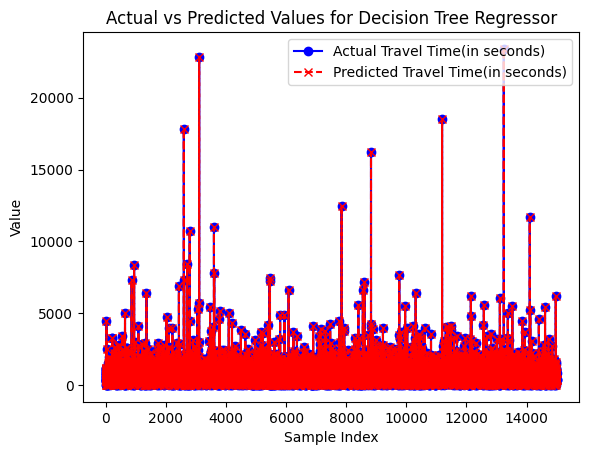

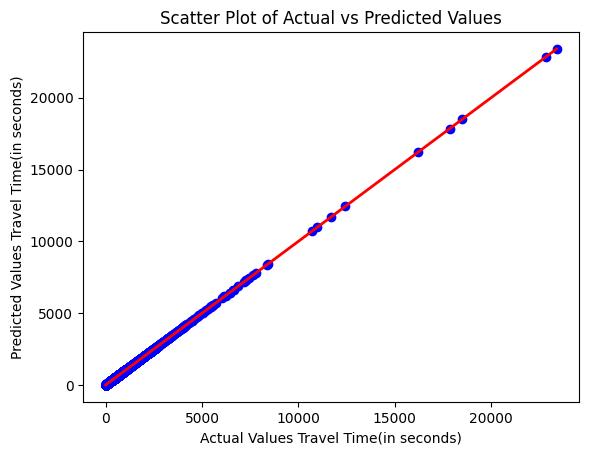

In [ ]:
import matplotlib.pyplot as plt

# Line plot: Predicted vs. Actual values on the Test set


# Plotting actual values
plt.plot(y_test.values, label="Actual Travel Time(in seconds)", color='b', marker='o')
# Plotting predicted values
plt.plot(y_test_pred, label="Predicted Travel Time(in seconds)", color='r', linestyle='--', marker='x')

plt.title('Actual vs Predicted Values for Decision Tree Regressor')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()

plt.show()

# Scatter plot: Predicted vs. Actual values on the Test set


plt.scatter(y_test.values, y_test_pred, color='blue')
plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], color='red', linewidth=2)

plt.title('Scatter Plot of Actual vs Predicted Values')
plt.xlabel('Actual Values Travel Time(in seconds)')
plt.ylabel('Predicted Values Travel Time(in seconds)')

plt.show()



In [ ]:
# hill climb not required
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
from math import sqrt

# Initial hyperparameter
current_depth = 5  # Start with a random or average value for max_depth
step_size = 1  # Define the step size for neighbor search
max_iter = 30  # Set a maximum number of iterations
best_depth = current_depth

# Initialize model and evaluate performance
tree = DecisionTreeRegressor(max_depth=current_depth)
tree.fit(X_train, y_train)
best_train_rmse = sqrt(mse(y_train.values, tree.predict(X_train)))

for i in range(max_iter):
    print(f"Iteration {i+1}: Current depth = {current_depth}, Train RMSE = {best_train_rmse}")

    # Try a neighboring configuration
    new_depth = current_depth + step_size
    if new_depth <= 0 or new_depth > max(depth):  # Ensure depth is within valid range
        break

    # Train and evaluate the new model
    tree = DecisionTreeRegressor(max_depth=new_depth)
    tree.fit(X_train, y_train)
    new_train_rmse = sqrt(mse(y_train.values, tree.predict(X_train)))

    # Compare performances
    if new_train_rmse < best_train_rmse:
        best_depth = new_depth
        best_train_rmse = new_train_rmse
        current_depth = new_depth
    else:
        # If no improvement, break the loop (you could also consider reducing the step size)
        break

# Final model with the best max_depth found
print(f"Best max_depth found: {best_depth} with Train RMSE: {best_train_rmse}")

# Evaluate on the test set
tree = DecisionTreeRegressor(max_depth=best_depth)
tree.fit(X_train, y_train)
y_test_pred = tree.predict(X_test)
print("Test Results for Optimized Decision Tree Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))


Iteration 1: Current depth = 5, Train RMSE = 43.847453106811706
Iteration 2: Current depth = 6, Train RMSE = 21.279594401800253
Iteration 3: Current depth = 7, Train RMSE = 9.994343173461566
Iteration 4: Current depth = 8, Train RMSE = 3.6765794684254804
Iteration 5: Current depth = 9, Train RMSE = 1.1708655082802182
Iteration 6: Current depth = 10, Train RMSE = 0.3080889987792994
Iteration 7: Current depth = 11, Train RMSE = 0.0
Best max_depth found: 11 with Train RMSE: 0.0
Test Results for Optimized Decision Tree Regressor Model:
--------------------------------------------------
Root mean squared error:  31.988826174150248
R-squared:  0.9976411084080264


In [ ]:
pip install deap

#### 6. XGBoost

In [ ]:
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

In [ ]:
print(model.best_estimator_)
model.best_params_

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [ ]:
print("Train Results for XGBoost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

In [ ]:
print("Test Results for XGBoost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error as mse, r2_score
from math import sqrt
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for RandomizedSearchCV
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}

# Initialize and fit RandomizedSearchCV
model = RandomizedSearchCV(XGBRegressor(), tuned_params, n_iter=20, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.best_params_)

# Predict results
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Print metrics
print("Train Results for XGBoost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train, y_train_pred)))
print("R-squared: ", r2_score(y_train, y_train_pred))

print("Test Results for XGBoost Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

# Prepare data for Matplotlib
train_df = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Line plot for Train data
plt.figure(figsize=(12, 6))
plt.plot(train_df['Actual'].values, label='Actual', color='blue')
plt.plot(train_df['Predicted'].values, label='Predicted', color='red', linestyle='--')
plt.title('Train Data: Actual vs Predicted for XGBoost')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot for Train data
plt.figure(figsize=(12, 6))
plt.scatter(train_df['Actual'], train_df['Predicted'], color='blue', alpha=0.5)
plt.plot([train_df['Actual'].min(), train_df['Actual'].max()], [train_df['Actual'].min(), train_df['Actual'].max()], color='red', linestyle='--')
plt.title('Train Data: Actual vs Predicted for XGBoost')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()

# Line plot for Test data
plt.figure(figsize=(12, 6))
plt.plot(test_df['Actual'].values, label='Actual', color='blue')
plt.plot(test_df['Predicted'].values, label='Predicted', color='red', linestyle='--')
plt.title('Test Data: Actual vs Predicted for XGBoost')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot for Test data
plt.figure(figsize=(12, 6))
plt.scatter(test_df['Actual'], test_df['Predicted'], color='blue', alpha=0.5)
plt.plot([test_df['Actual'].min(), test_df['Actual'].max()], [test_df['Actual'].min(), test_df['Actual'].max()], color='red', linestyle='--')
plt.title('Test Data: Actual vs Predicted for XGBoost')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()


#### 7. Random Forest Regressor

In [ ]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
random_regressor = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter = 20, scoring = 'neg_mean_absolute_error', cv = 5, n_jobs = -1)
random_regressor.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(random_regressor.best_estimator_)
random_regressor.best_params_

In [ ]:
y_train_pred = random_regressor.predict(X_train)
y_test_pred = random_regressor.predict(X_test)

In [ ]:
print("Train Results for Random Forest Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

In [ ]:
print("Test Results for Random Forest Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

In [ ]:
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse, r2_score
from math import sqrt
import pandas as pd

# Define hyperparameters for RandomizedSearchCV
tuned_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomizedSearchCV with RandomForestRegressor
random_regressor = RandomizedSearchCV(
    RandomForestRegressor(),
    tuned_params,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    random_state=42  # Optional for reproducibility
)

# Fit the model
random_regressor.fit(X_train, y_train)

# Check if the model was fitted properly and attributes are accessible
if hasattr(random_regressor, 'best_estimator_'):
    best_estimator = random_regressor.best_estimator_
    best_params = random_regressor.best_params_

    # Print the best estimator and best parameters
    print("Best Estimator:", best_estimator)
    print("Best Parameters:", best_params)

    # Predict train and test results using the best estimator
    y_train_pred = best_estimator.predict(X_train)
    y_test_pred = best_estimator.predict(X_test)

    # Print evaluation metrics for the training set
    print("Train Results for Random Forest Regressor Model:")
    print(50 * '-')
    print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
    print("R-squared: ", r2_score(y_train.values, y_train_pred))

    # Print evaluation metrics for the test set
    print("Test Results for Random Forest Regressor Model:")
    print(50 * '-')
    print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
    print("R-squared: ", r2_score(y_test, y_test_pred))

    # Predict travel time for a random taxi trip in the test set
    # Select a random index from the test set
    random_index = random.randint(0, len(X_test) - 1)

    # Extract features for the randomly selected trip
    random_taxi_trip = X_test.iloc[random_index].values.reshape(1, -1) if isinstance(X_test, pd.DataFrame) else X_test[random_index].reshape(1, -1)

    # Predict the travel time for the selected random taxi trip
    predicted_travel_time = best_estimator.predict(random_taxi_trip)

    # Output the predicted travel time
    print(f"Predicted Travel Time for Random Taxi Trip ID {random_index}: {predicted_travel_time[0]} seconds")

    # Output the actual travel time for comparison (if desired)
    actual_travel_time = y_test.iloc[random_index] if isinstance(y_test, pd.Series) else y_test[random_index]
    print(f"Actual Travel Time for Taxi Trip ID {random_index}: {actual_travel_time} seconds")
else:
    print("The model has not been fitted properly or the attribute 'best_estimator_' is not available.")


Best Estimator: RandomForestRegressor(min_samples_leaf=2, n_estimators=300)
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2}
Train Results for Random Forest Regressor Model:
--------------------------------------------------
Root mean squared error:  41.65334464051644
R-squared:  0.9964196836584048
Test Results for Random Forest Regressor Model:
--------------------------------------------------
Root mean squared error:  26.953934951914
R-squared:  0.9983252278656085
Predicted Travel Time for Random Taxi Trip ID 9087: 645.0 seconds
Actual Travel Time for Taxi Trip ID 9087: 645 seconds


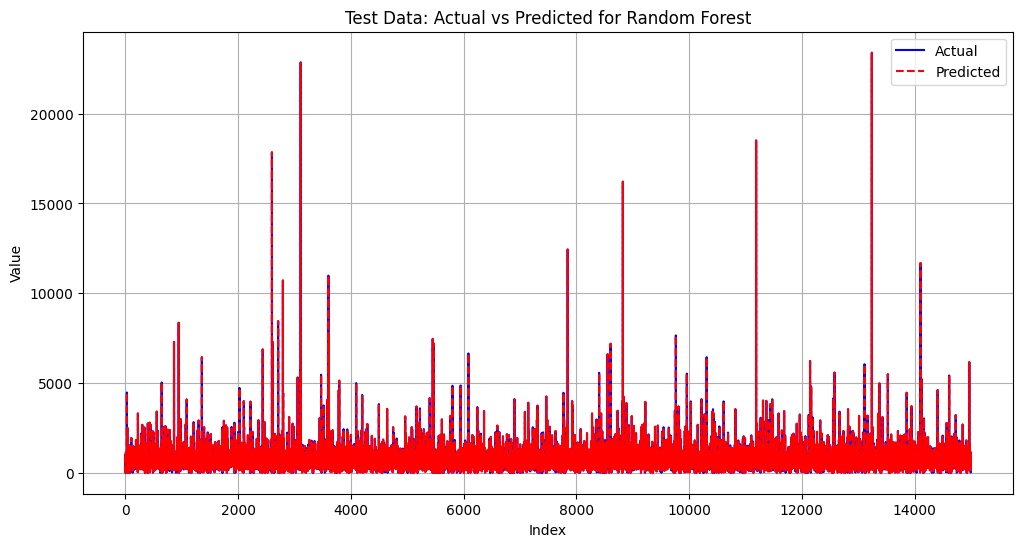

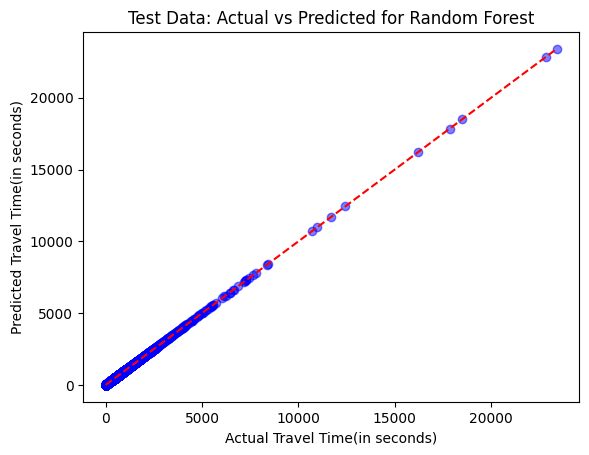

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# from sklearn.metrics import mean_squared_error as mse, r2_score
# from math import sqrt
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV

# # Define the parameter grid for RandomizedSearchCV
# tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

# # Initialize and fit RandomizedSearchCV
# random_regressor = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter=20, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
# random_regressor.fit(X_train, y_train)

# print(random_regressor.best_estimator_)
# print(random_regressor.best_params_)

# # Predict results
# y_train_pred = random_regressor.predict(X_train)
# y_test_pred = random_regressor.predict(X_test)

# # Print metrics
# print("Train Results for Random Forest Regressor Model:")
# print(50 * '-')
# print("Root mean squared error: ", sqrt(mse(y_train, y_train_pred)))
# print("R-squared: ", r2_score(y_train, y_train_pred))

# print("Test Results for Random Forest Regressor Model:")
# print(50 * '-')
# print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
# print("R-squared: ", r2_score(y_test, y_test_pred))

# Prepare data for Matplotlib
train_df = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# # Line plot for Train data
# plt.figure(figsize=(12, 6))
# plt.plot(train_df['Actual'].values, label='Actual', color='blue')
# plt.plot(train_df['Predicted'].values, label='Predicted', color='red', linestyle='--')
# plt.title('Train Data: Actual vs Predicted for Random Forest')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Scatter plot for Train data
# plt.figure(figsize=(12, 6))
# plt.scatter(train_df['Actual'], train_df['Predicted'], color='blue', alpha=0.5)
# plt.plot([train_df['Actual'].min(), train_df['Actual'].max()], [train_df['Actual'].min(), train_df['Actual'].max()], color='red', linestyle='--')
# plt.title('Train Data: Actual vs Predicted for Random Forest')
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.grid(True)
# plt.show()

# Line plot for Test data
plt.figure(figsize=(12, 6))
plt.plot(test_df['Actual'].values, label='Actual', color='blue')
plt.plot(test_df['Predicted'].values, label='Predicted', color='red', linestyle='--')
plt.title('Test Data: Actual vs Predicted for Random Forest')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot for Test data
# plt.figure(figsize=(12, 6))
plt.scatter(test_df['Actual'], test_df['Predicted'], color='blue', alpha=0.5)
plt.plot([test_df['Actual'].min(), test_df['Actual'].max()], [test_df['Actual'].min(), test_df['Actual'].max()], color='red', linestyle='--')
plt.title('Test Data: Actual vs Predicted for Random Forest')
plt.xlabel('Actual Travel Time(in seconds)')
plt.ylabel('Predicted Travel Time(in seconds)')
# plt.grid(True)
plt.show()


#### 8. Stacking

In stacking method we stack many different ML models to get the better results.

In [ ]:
# Initializing models
ridge = Ridge()
lasso = Lasso()
tree = DecisionTreeRegressor()
knn = KNeighborsRegressor()

stack = StackingRegressor(regressors = [tree, lasso, knn], meta_regressor = ridge)
stack.fit(X_train, y_train)

StackingRegressor(meta_regressor=Ridge(),
                  regressors=[DecisionTreeRegressor(), Lasso(),
                              KNeighborsRegressor()])

In [ ]:
print(stack.regr_)
stack.meta_regr_

[DecisionTreeRegressor(), Lasso(), KNeighborsRegressor()]


Ridge()

In [ ]:
y_train_pred = stack.predict(X_train)
y_test_pred = stack.predict(X_test)

In [ ]:
print("Train Results for Stacking Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

Train Results for Stacking Regressor Model:
--------------------------------------------------
Root mean squared error:  2.795194097865048e-07
R-squared:  1.0


In [ ]:
print("Test Results for Stacking Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

Test Results for Stacking Regressor Model:
--------------------------------------------------
Root mean squared error:  16.012067965658165
R-squared:  0.9994089744931164


In [ ]:
import random
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
from math import sqrt
import pandas as pd

# Initialize base regressors and meta-regressor
ridge = Ridge()
lasso = Lasso()
tree = DecisionTreeRegressor()
knn = KNeighborsRegressor()

# Initialize Stacking Regressor
stack = StackingRegressor(
    estimators=[('tree', tree), ('lasso', lasso), ('knn', knn)],
    final_estimator=ridge
)

# Fit the model
stack.fit(X_train, y_train)

# Print the fitted models
print("Base Regressors:")
for name, model in stack.named_estimators_.items():
    print(f"{name}: {model}")

print("Meta Regressor:")
print(stack.final_estimator_)

# Predict train and test results
y_train_pred = stack.predict(X_train)
y_test_pred = stack.predict(X_test)

# Print evaluation metrics for the training set
print("Train Results for Stacking Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_train.values, y_train_pred)))
print("R-squared: ", r2_score(y_train.values, y_train_pred))

# Print evaluation metrics for the test set
print("Test Results for Stacking Regressor Model:")
print(50 * '-')
print("Root mean squared error: ", sqrt(mse(y_test, y_test_pred)))
print("R-squared: ", r2_score(y_test, y_test_pred))

# Predict travel time for a random taxi trip in the test set
# Select a random index from the test set
random_index = random.randint(0, len(X_test) - 1)

# Extract features for the randomly selected trip
random_taxi_trip = X_test.iloc[random_index].values.reshape(1, -1) if isinstance(X_test, pd.DataFrame) else X_test[random_index].reshape(1, -1)

# Predict the travel time for the selected random taxi trip
predicted_travel_time = stack.predict(random_taxi_trip)

# Output the predicted travel time
print(f"Predicted Travel Time for Random Taxi Trip ID {random_index}: {predicted_travel_time[0]} seconds")

# Output the actual travel time for comparison (if desired)
actual_travel_time = y_test.iloc[random_index] if isinstance(y_test, pd.Series) else y_test[random_index]
print(f"Actual Travel Time for Taxi Trip ID {random_index}: {actual_travel_time} seconds")


Base Regressors:
tree: DecisionTreeRegressor()
lasso: Lasso()
knn: KNeighborsRegressor()
Meta Regressor:
Ridge()
Train Results for Stacking Regressor Model:
--------------------------------------------------
Root mean squared error:  0.009817647196889323
R-squared:  0.9999999998010992
Test Results for Stacking Regressor Model:
--------------------------------------------------
Root mean squared error:  0.00475203145039674
R-squared:  0.9999999999479441
Predicted Travel Time for Random Taxi Trip ID 6662: 855.0005744858202 seconds
Actual Travel Time for Taxi Trip ID 6662: 855 seconds


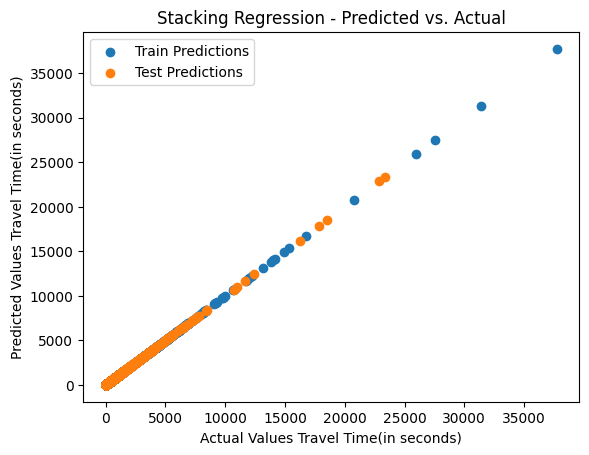

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_train, y_train_pred, label='Train Predictions')
plt.scatter(y_test, y_test_pred, label='Test Predictions')
plt.xlabel('Actual Values Travel Time(in seconds)')
plt.ylabel('Predicted Values Travel Time(in seconds)')
plt.title('Stacking Regression - Predicted vs. Actual')
plt.legend()
plt.show()

From the above all the models that we have trained most of them are overfitted including some ensemble teachniques also. But the random forest algorithm gives pretty good results. So the random forest is the best suited model for this dataset.

#### Save the winnig model to disk

In [ ]:
win_model = RandomForestRegressor(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1)
win_model.fit(X_train, y_train)
joblib.dump(win_model, 'winnig_model_random_forest.pkl')